# Using Pytorch Easily from Scratch! (SegNet)

Import note for the following script: 

The output of the soft-max classifier is a K channel image of probabilities where K is the number of classes. The predicted segmentation corresponds to the class with maximum probability at each pixel. In order to feed the neural network with necessary elements, the masks have to be of the same kind in order for the training to work. 

Learning how to use pytorch in a very easy way, compared to different devices. This utility has the reason to teach how to use pytorch fram scratch. I deduce that tensorflow has a very similar approach

In [14]:
import os
import numpy as np
import scipy
import pandas as pd
import torch
from pathlib import Path
from pprint import pprint
from torchvision import transforms
import matplotlib.pyplot as plt
# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
from PIL import Image as IMG
from src.utils_processimage import *
# from albumentations import torch as AT
plt.style.use('bmh')
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
from torchmetrics.functional.segmentation import mean_iou

# Become one with tha data ! 

Let's understand in a very good way what we are looking at honestly: 


In [16]:
path_example = Path("data/idd20k_lite/train/512")
img = IMG.open(os.path.join(path_example,"frame1434_image.jpg")).convert("RGB")
mask = IMG.open(os.path.join(path_example,"frame1434_inst_label.png")).convert("L")
label_mask = IMG.open(os.path.join(path_example,"frame1434_label.png")).convert("L")

print(f"Shape of the images; {img}")
print(f"Range of the values; {np.max(img),np.min(img)}")
print(f"Shape of the mask; {mask}")
print(f"Range of the mask; {np.min(mask),np.max(mask)}")
print(f"Unique values of mask: {np.unique(mask)}")
print(f"Shape of the label_mask; {label_mask}")
print(f"Range of the label_mask; {np.min(label_mask),np.max(label_mask)}")
print(f"Unique values of label_mask: {np.unique(label_mask)}")

Shape of the images; <PIL.Image.Image image mode=RGB size=320x227 at 0x7F7140EE8510>
Range of the values; (255, 0)
Shape of the mask; <PIL.Image.Image image mode=L size=320x227 at 0x7F71434DB090>
Range of the mask; (0, 255)
Unique values of mask: [  0   1   2   3   4   5   6 255]
Shape of the label_mask; <PIL.Image.Image image mode=L size=320x227 at 0x7F7140EE8650>
Range of the label_mask; (0, 255)
Unique values of label_mask: [  0   1   2   3   4   5   6 255]


So i have iamge in RBG and then masks with values from 0 to 6 for some classes and 255 as the backgorund ! 

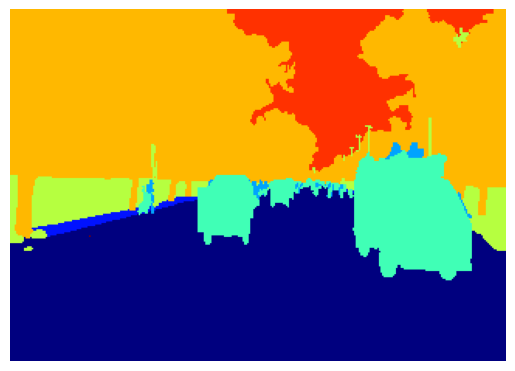

tensor([[[1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         ...,
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000]],

        [[1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         ...,
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000]],

        [[1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         ...,
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000],
         [1.0000, 0.7249, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         ...,
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000]],

        [[0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.5000],
         [0.

In [17]:
plot_combined_masks(generate_binary_masks(mask), show_plot=True)

## Loading Images in the `Image Loader`

Turning the image data into a `Dataset` pytorch can use. 

1st: getting a list of all the images under a png fomrat and a jpg fomrat using a function which recusively looks for the specific files. The images will be passed via a list, in the future in an array for faster implemtatnions. 

2nd: the dataclass is loaded so the neural network has as input the original image in RGB and as output the mask with specific ids for each single element. 

In [18]:
import os
from torch.utils.data import Dataset, DataLoader, random_split


# Function which can receive and returns the list of files inside a specific folder
def list_png_files(root_folder, extension):
    png_files = []
    for folder, _, files in os.walk(root_folder):
        if "test" not in folder.lower():
            for file in files:
                if file.lower().endswith(extension) and "_inst" not in file.lower():
                    png_files.append(os.path.join(folder, file))
    return png_files


# Example usage:
root_directory = 'data/idd20k_lite'
png_files_list = list_png_files(root_directory,'.png')
jpg_files_list = list_png_files(root_directory,'.jpg')
print(png_files_list)
print(jpg_files_list)
# error if png filesa re different compared ot jpg files
print("Count of Images: {}".format(len(jpg_files_list)))
print("Count of Masks: {}".format(len(png_files_list)))
print(sorted(png_files_list))
print(sorted(jpg_files_list))

train_dir = 'data/idd20k_lite/train'
val_dir = 'data/idd20k_lite/val'



['data/idd20k_lite/val/181/016719_label.png', 'data/idd20k_lite/val/181/013948_label.png', 'data/idd20k_lite/val/181/001500_label.png', 'data/idd20k_lite/val/181/016119_label.png', 'data/idd20k_lite/val/379/frame46571_label.png', 'data/idd20k_lite/val/379/frame80048_label.png', 'data/idd20k_lite/val/379/frame37118_label.png', 'data/idd20k_lite/val/379/frame28338_label.png', 'data/idd20k_lite/val/379/frame21797_label.png', 'data/idd20k_lite/val/379/frame45784_label.png', 'data/idd20k_lite/val/379/frame9094_label.png', 'data/idd20k_lite/val/379/frame23283_label.png', 'data/idd20k_lite/val/205/frame5153_label.png', 'data/idd20k_lite/val/205/frame5783_label.png', 'data/idd20k_lite/val/533/frame5719_label.png', 'data/idd20k_lite/val/533/frame0079_label.png', 'data/idd20k_lite/val/272/frame0144_label.png', 'data/idd20k_lite/val/172/874002_label.png', 'data/idd20k_lite/val/172/894999_label.png', 'data/idd20k_lite/val/172/178400_label.png', 'data/idd20k_lite/val/172/164487_label.png', 'data/id

# Custom Dataset for Image Segmentation
 
Creating a custom Dataset Subclkass in order to feed to the SegNet a image and a mask

## Making Masks throrugh Segnet 

There is a sublte and very subtle difference when you want to make a final prediction of what is happening. 

In [19]:
LEARNING_RATE = 3e-3
BATCH_SIZE = 4
EPOCHS = 5
# Setup batch size and number of workers 
NUM_WORKERS = os.cpu_count()

In [20]:
def generate_binary_masks(image):
    # Convert PIL image to PyTorch tensor
    image_tensor = torch.tensor(np.array(image))
    
    # Get unique values in the image tensor
    unique_values = torch.unique(image_tensor)
    
    # Initialize an empty tensor to store binary masks
    masks = torch.zeros(8, image_tensor.shape[0], image_tensor.shape[1], dtype=torch.uint8)
    
    # For each unique value, generate a binary mask
    for id_mask, value in enumerate(unique_values):
        masks[id_mask,:,:] = torch.where(image_tensor == value, 1, 0)
    
    return masks

In [21]:
class CarvanaDataset(Dataset):
    def __init__(self, root_directory):
        #getting the root directory of the files
        self.root_directory = root_directory

        # Importing the images from the file list for their extension
        self.images = sorted(list_png_files(root_directory,'.jpg'))
        self.masks = sorted(list_png_files(root_directory,'.png'))

        # applying a resizing for the neural network to understand them better
        self.transform_train = transforms.Compose([
             transforms.Resize((224, 224)),
             transforms.ToTensor()]
            )
        
        # https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
        # Because the input image is scaled to [0.0, 1.0], this transformation should not be used when transforming target image masks. 
        #See the references for implementing the transforms for image masks.
        
        self.transform_test = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(dtype=torch.float32)
        ])

        self.transform_binary = transforms.Compose([
            transforms.Resize((224,224))
        ])
    
    # Get item to pass the images to the dataloader
    def __getitem__(self, index):
        img = IMG.open(self.images[index]).convert("RGB")   # passing the raw image
        masks = IMG.open(self.masks[index]).convert("L")    # passing the only channel mask
        binary_masks = generate_binary_masks(masks)
        

        return self.transform_train(img), self.transform_binary(binary_masks)    # returning the images transformed

    def __len__(self):
    # returning the length of the dataset
        return len(self.images)

In [22]:
dataset = CarvanaDataset(root_directory=root_directory)   # creating the instance
generator = torch.Generator().manual_seed(42)             # adding a generator 

In [23]:
# splitting the dataset into specific elements for train and validation
train_dataset, val_dataset = random_split(dataset, [0.7, 0.3], generator=generator)

# Loading the dataloaders
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

train_dataloader, val_dataloader
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

Creating DataLoader's with batch size 4 and 8 workers.


In [24]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, mask_batch = next(iter(train_dataloader))

## Importing and Testing Model

Testing if the dataloaders work properly and if the neural netword is able to pass a forward inference of the image ! If this work only the training loop is necessary. 

In [25]:
from src.models_seg import SegNet, SegNetMini
from torch import optim, nn
from tqdm import tqdm

model = SegNetMini(classes=8)
# One Put works
x = torch.rand(1,3,224,224) # -> it is tensor
x[0,:,:,:] = img_batch[0]
print(model(x).shape)
output = model(x).detach().numpy()

torch.Size([1, 8, 224, 224])


## PLotting a 1st inference

Let's plot an image and compare it to the original mask, and see what do we get ! 

* Original Mask: [ 3, height, width]
* PLot Image: [ 1, height, width]
* Predicted Mask:  [ 1, height, width]



In [26]:
print("IAMGES:")
print(f"Shape of the images; {img_batch[0].shape}")
min, max= torch.aminmax(img_batch[0])
print(f"Range of the values; {min.item(),max.item()} \n TYPE: {img_batch[0].dtype}\n")

print("MASKS:")
print(f"Shape of the mask; {mask_batch[0].shape}")
min, max= torch.aminmax(mask_batch[0])
print(f"Range of the mask; {min.item(),max.item()} \n  TYPE: {model(x).dtype}\n")

print("MODEL:")
print(f"Shape of the model: {model(x).shape}")
min, max= torch.aminmax(model(x))
print(f"Range of the MODEL; {min.item(),max.item()} \n TYPE: {model(x).dtype} \n\n")

print(f"Shape of the IMAGES in the BATCH: {img_batch.shape} based on the BATCH_SIZE: {BATCH_SIZE} of TYPE:  {img_batch.dtype}\n")
print(f"Shape of the MASK in the BATCH: {mask_batch.shape} based on the BATCH_SIZE: {BATCH_SIZE} of TYPE:  {img_batch.dtype}\n")

IAMGES:
Shape of the images; torch.Size([3, 224, 224])
Range of the values; (0.0, 1.0) 
 TYPE: torch.float32

MASKS:
Shape of the mask; torch.Size([8, 224, 224])
Range of the mask; (0, 1) 
  TYPE: torch.float32

MODEL:
Shape of the model: torch.Size([1, 8, 224, 224])
Range of the MODEL; (-3.2559449672698975, 5.285896301269531) 
 TYPE: torch.float32 


Shape of the IMAGES in the BATCH: torch.Size([4, 3, 224, 224]) based on the BATCH_SIZE: 4 of TYPE:  torch.float32

Shape of the MASK in the BATCH: torch.Size([4, 8, 224, 224]) based on the BATCH_SIZE: 4 of TYPE:  torch.float32



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


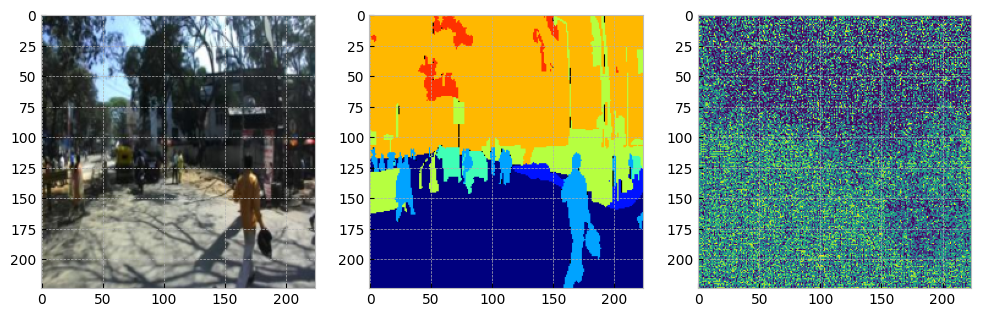

In [27]:
# PLotting one mask compared to the original one to understand if the process is working correctly
plt.figure(figsize=([12,8]))  # PLotting the image in a correct way 
img = img_batch[1]            # Getting the 1st image
img = np.transpose(img,(1,2,0))
rescaled_pred = scipy.special.softmax(output,axis=1)
rescaled_pred = np.argmax(rescaled_pred,axis=1)   # only for inference

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(plot_combined_masks(mask_batch[1])) 
plt.subplot(1,3,3)
plt.imshow(np.transpose(rescaled_pred,(1,2,0)))

This is ain't working not only for the plotting, but also because you have to encode also the masks in some way ! i still have to figure out this specific element let's say ok ?! 

# Training Loop

In [30]:
torch.cuda.empty_cache()   # To empty all the cache in th GPU 
model = SegNet(classes=8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# criterion = nn.BCELoss()
criterion = mean_iou

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        
        y_pred = model.postprocessing(y_pred)
        optimizer.zero_grad()

        #print(f"OUTPUT SHAPE: {y_pred.shape} and TYPE: {y_pred.dtype}")
        #print(f"OUTPUT SHAPE: {y_pred.shape} and TYPE: {y_pred.dtype}")
        loss = criterion(y_pred, mask, 8)
        #print(f"LOSS: {loss.item()} for {idx}")
        train_running_loss += loss.item()

         
        loss.backward()    # computed the gradients based on the criterion
        optimizer.step()   # After computing the gradients using loss.backward(), the next step is to update the model parameters (weights and biases) using an optimization algorithm.
 
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            
            y_pred = model(img)
            y_pred = model.postprocessing(y_pred)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print("-"*30)

# torch.save(model.state_dict(), MODEL_SAVE_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: one_hot is only applicable to index tensor.

## Inference 

IT works, it just needs more training let's say. 

torch.Size([4, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 3, 4, 5, 6], device='cuda:0')


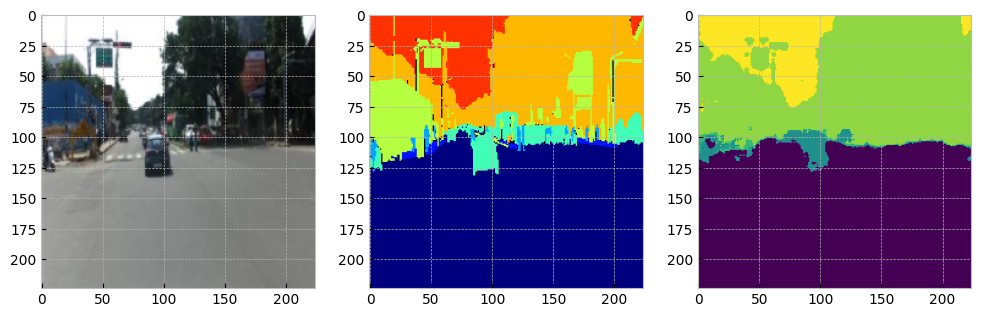

In [82]:
import random
img_batch_val, mask_batch_val = next(iter(val_dataloader))
idx = random.randint(0,BATCH_SIZE-1)
img = img_batch_val
mask = mask_batch_val[0]
output = model(img.cuda())
# PLotting one mask compared to the original one to understand if the process is working correctly
plt.figure(figsize=([12,8]))  # PLotting the image in a correct way 
img = img_batch_val[0]            # Getting the 1st image
img = np.transpose(img,(1,2,0))
#rescaled_pred = scipy.special.softmax(output,axis=1)
print(img_batch_val.shape)
rescaled_pred = torch.argmax(output[0,:,:,:],axis=0)   # only for inference
print(rescaled_pred.unique())

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(plot_combined_masks(mask)) 
plt.subplot(1,3,3)
plt.imshow(rescaled_pred.cpu())

## Output Tensor

Once we pass the input tensor into our trained model, we then need to apply softmax on the output tensor. After applying softmax, we then apply argmax to get which channel has the highest softmax-ed value among the 19 channels.

In [ ]:
# Apply softmax along dimension 0 (you can choose a different dimension if needed)
softmax_output = torch.nn.Softmax(dim=1)(model(x)[0,:,:,:])
print("Softmax output:", softmax_output)
min, max= torch.aminmax(softmax_output)
print(f"Range of the values; {min.item(),max.item()}")
# Find the index of the maximum value in the softmax output 
mask_softmax = torch.zeros_like(softmax_output)
#for i in range(0,softmax_output.shape(0)):
#    mask_softmax = 
rescale_mask = (softmax_output * 255).to(torch.uint8)
argmax = torch.argmax(softmax_output[0,:,:],dim=0)
rescale_mask.shape

Softmax output: tensor([[[0.0030, 0.0046, 0.0037,  ..., 0.0040, 0.0042, 0.0036],
         [0.0039, 0.0055, 0.0042,  ..., 0.0048, 0.0048, 0.0038],
         [0.0042, 0.0046, 0.0056,  ..., 0.0033, 0.0042, 0.0047],
         ...,
         [0.0050, 0.0038, 0.0052,  ..., 0.0045, 0.0043, 0.0037],
         [0.0039, 0.0038, 0.0044,  ..., 0.0039, 0.0041, 0.0041],
         [0.0039, 0.0044, 0.0042,  ..., 0.0040, 0.0044, 0.0051]]],
       grad_fn=<SoftmaxBackward0>)
Range of the values; (0.0006130404071882367, 0.022130843251943588)


torch.Size([1, 224, 224])